# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/GeneralFunctions")

Wall time: 0 ns


# Import TensorFieldData

## Import Data

In [2]:
%%time
import scipy.io as sio
import numpy as np

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../Data/TensorField/TensorFieldData_DoubleGyre_LCS.mat')

X = mat_file['X']
Y = mat_file['Y']
time = mat_file['time']
C11 = mat_file['C11']
C12 = mat_file['C12']
C22 = mat_file['C22']
lam1 = mat_file['lam1']
lam2 = mat_file['lam2']
v1 = mat_file['v1']
v2 = mat_file['v2']
C11_x = mat_file['C11x']
C11_y = mat_file['C11y']
C12_x = mat_file['C12x']
C12_y = mat_file['C12y']
C22_x = mat_file['C22x']
C22_y = mat_file['C22y']

Ncores = 18

Wall time: 175 ms


## Interpolate $ \dot{\phi}(x, y, \phi) $ 

In [3]:
%%time
from math import atan
from ipynb.fs.defs.phi_prime import _phi_prime
from tqdm.notebook import tqdm

# Interpolant phi_phrime
interp_phi_prime = _phi_prime(X, Y, lam1, C11, C12, C22, C11_x, C11_y, C12_x, C12_y, C22_x, C22_y, Ncores)

Wall time: 3min


In [4]:
PHI = np.zeros(X.shape)*np.nan

for i in tqdm(range(X.shape[0])):
    
    for j in range(X.shape[1]):
    
        if np.isfinite(v1[i, j, 0]):
            v = v1[i, j, :]
            phi = atan(v[1]/v[0])%(2*np.pi)
        
            x = [Y[i, j], X[i, j], phi]
        
            PHI[i, j] = interp_phi_prime(x)

  0%|          | 0/201 [00:00<?, ?it/s]

# Find repelling LCS

In [5]:
## Initial conditions of repelling LCS are given by fin

In [6]:
from ipynb.fs.defs.loc_max import _loc_max
max_distance = .1

loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(max_distance, X, Y, lam2)

x0lam2 = loc_max_x
y0lam2 = loc_max_y

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
from math import atan, cos, sin

v = v1.copy()
phi0lam2 = []

for i in range(len(loc_idx_x)):
    eigenvector = v[loc_idx_y[i], loc_idx_x[i], :]
    phi0lam2.append(atan(eigenvector[1]/eigenvector[0])%(2*np.pi))

In [8]:
# Interpolant lambda_1
from scipy.interpolate import RectBivariateSpline as RBS
interp_lambda = RBS(Y[:,0], X[0,:], np.nan_to_num(lam1, nan = 1))

In [9]:
from scipy.integrate import solve_ivp
from ipynb.fs.defs.geodesic_equation import _geodesic_equation

def launch_trajectories(x0, y0, phi0):
        
        y0 = [x0, y0, phi0]
        
        sol = solve_ivp(_geodesic_equation, t, y0, 'BDF', t_eval, rtol=1e-6, atol=1e-6, args=(interp_phi_prime, interp_lambda, X, Y, defined_domain))         
    
        x = sol.y[0,:]
        y = sol.y[1,:]
        phi = sol.y[2,:]
        
        return sol

In [10]:
# define integration domain of dummy variable
t = [0, 1.75]

# define resolution of trajectories
t_eval = np.linspace(t[0], t[1], 10000)

defined_domain = np.isfinite(lam2).astype(int)

x = [x0lam2[0], y0lam2[0], phi0lam2[0]]

#solODE = Parallel(n_jobs=Ncores, verbose = 0)(delayed(launch_trajectories)(x0lam2[i], y0lam2[i], phi0lam2[i]) for i in tqdm(range(len(x0lam2))))
solODE = launch_trajectories(x[0], x[1], x[2])

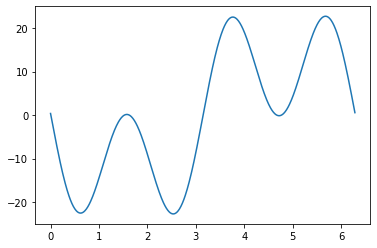

In [11]:
import matplotlib.pyplot as plt

phi_dot = []
for i in np.arange(0, 2*np.pi, 0.01):
    phi_dot.append(interp_phi_prime([x[1], x[0], i]))

fig = plt.figure()
ax = plt.axes()
ax.plot(np.arange(0, 2*np.pi, 0.01), phi_dot)
plt.show()

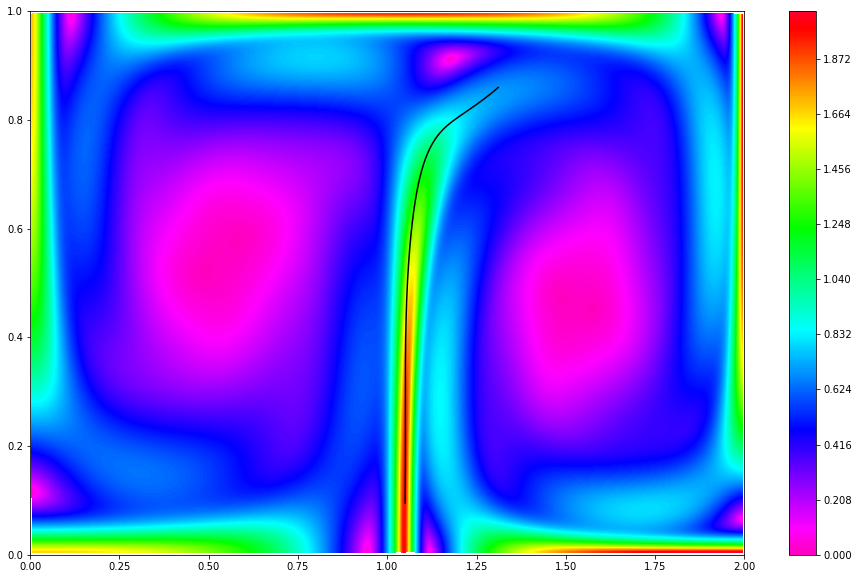

In [12]:
## FTLE-field
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
cax = ax.contourf(X, Y, np.log(lam2)/(time[0,-1]-time[0,0]), levels = 600, cmap = 'gist_rainbow_r')
plt.colorbar(cax)
ax.plot(solODE.y[0,:], solODE.y[1,:], c = "k")
plt.show()

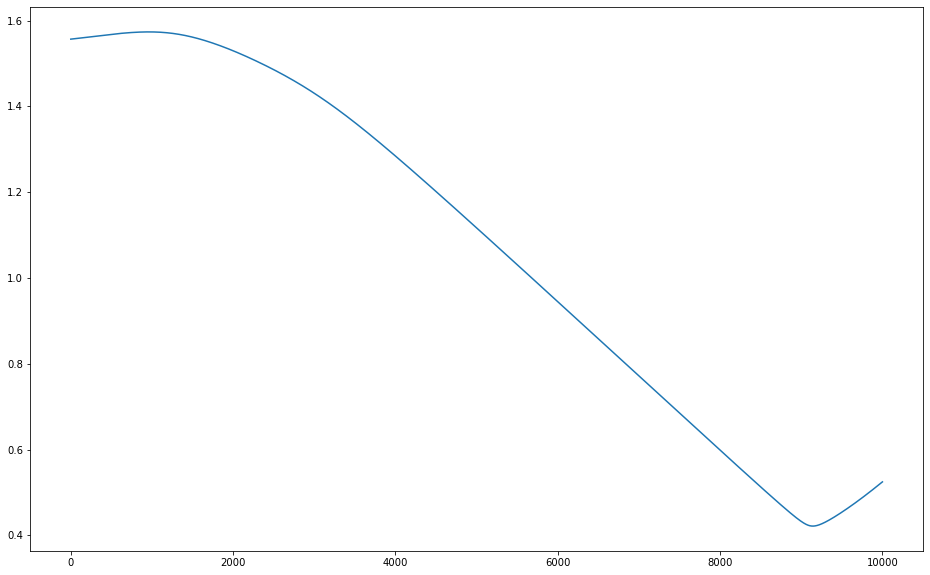

In [13]:
fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
ax.plot(solODE.y[2,:])
plt.show()